# Minst Data Exploration for Fully Connected Neural Network(FCNN) and Convolutional Neural Network(CNN)

### Demonstration of how to use class ReadAndLoadMnistData from module src.preprocess.preprocess in Jupyter notebook

## Data

(59999, 784) (59999,) (9999, 784) (9999,)
   0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.608  0.609  0.610  \
0  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
1  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
2  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
3  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   
4  0    0    0    0    0    0    0    0    0    0  ...      0      0      0   

   0.611  0.612  0.613  0.614  0.615  0.616  0.617  
0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0  

[5 rows x 784 columns]


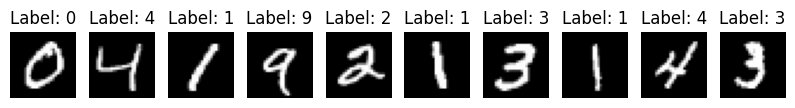

0    2
1    1
2    0
3    4
4    1
Name: 7, dtype: int64


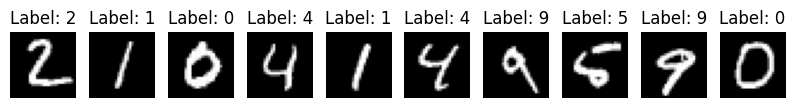

No exception occurred


In [15]:
import sys

# Add the parent directory to sys.path
sys.path.append('../')

from src.preprocess.preprocess import ReadAndLoadMnistData
from src.preprocess.preprocess import plot_images

# Using the ReadAndLoadMnistData class defined in the notebook
train_file = "../dataset/mnist_train.csv"
test_file = "../dataset/mnist_test.csv"

X_train, y_train, X_test, y_test = None, None, None, None

with ReadAndLoadMnistData(train_file, test_file) as mnist_data:
    X_train, y_train, X_test, y_test = mnist_data.load_data()
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    print(X_train.head())
    plot_images(X_train.values, y_train.values)
    print(y_test.head())
    plot_images(X_test.values, y_test.values)

In [2]:
y_train

0        0
1        4
2        1
3        9
4        2
        ..
59994    8
59995    3
59996    5
59997    6
59998    8
Name: 5, Length: 59999, dtype: int64

In [3]:
X_test

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_test

0       2
1       1
2       0
3       4
4       1
       ..
9994    2
9995    3
9996    4
9997    5
9998    6
Name: 7, Length: 9999, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.3, random_state=42, stratify=y_test)


In [17]:
print(f"Shape of X: {X_train.shape}")
print(f"Shape of y: {X_test.shape}")

print(f"Shape of X: {y_train.shape}")
print(f"Shape of y: {y_test.shape}")

Shape of X: (6999, 784)
Shape of y: (3000, 784)
Shape of X: (6999,)
Shape of y: (3000,)


# Full Connected Neural Network

## Imports

In [18]:
import numpy as np
import matplotlib.pyplot as plt
#matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, Flatten
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, recall_score

np.random.seed(0)

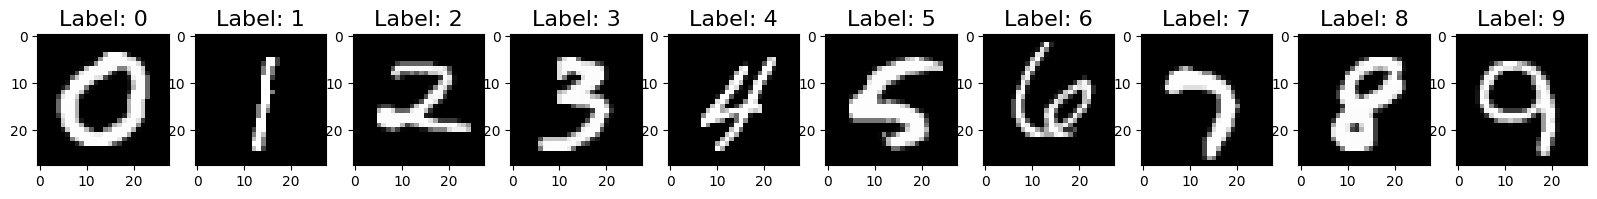

In [19]:
num_classes = 10

f, ax = plt.subplots(1, num_classes, figsize=(20, 20))

for i in range(0, num_classes):
    sample = X_train[y_train == i].iloc[0]
    ax[i].imshow(sample.values.reshape(28, 28), cmap='gray')
    ax[i].set_title("Label: {}".format(i), fontsize=16)

## y_train before One hot decoding

In [20]:
for i in range(10):
    print(y_train.iloc[i])

5
5
5
0
8
9
5
3
6
2


## One Hot Decoding
This dataset is pretty much balance. So, we don't have to any class balancing. However, we want classify the labels so we will be doing One hot decoding.

In [21]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"Shape of y_train after reshaping: {y_train.shape}")
print(f"Shape of y_test after reshaping: {y_test.shape}")

Shape of y_train after reshaping: (6999, 10)
Shape of y_test after reshaping: (3000, 10)


In [22]:
for i in range(10):
    print(y_train[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


## Prepare the Data

In [23]:
X_train.iloc[0].values

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  10,  47,
        64, 187, 212, 254, 161,  81,  45,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [24]:
# Normalize the images
x_train = X_train / 255.0       # Here x_train is still a pandas dataframe
x_test = X_test / 255.0         # Here x_test is still a pandas dataframe

x_train.shape

# x_train = X_train.values / 255.0       # Here x_train converts to numpy array
# x_test = X_test.values / 255.0         # Here x_test converts to numpy array

(6999, 784)

In [25]:
x_train.iloc[0].shape

(784,)

In [26]:
print(x_train.iloc[0].values)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## Create Model - FCNN

In [38]:
model = Sequential()
model.add(Input(shape=(784,)))

model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=10, activation='softmax'))

plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [39]:
batch_size = 512
epochs=10
model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3063 - loss: 2.0673  
Epoch 2/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7484 - loss: 0.9571
Epoch 3/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8305 - loss: 0.5582
Epoch 4/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8759 - loss: 0.4221
Epoch 5/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8986 - loss: 0.3430
Epoch 6/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9087 - loss: 0.3027
Epoch 7/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9257 - loss: 0.2632
Epoch 8/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9279 - loss: 0.2481
Epoch 9/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9368 - loss: 0.2120
Epoch 10/10
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9450 - loss: 0.1923


## Evaluate model

In [29]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9387 - loss: 0.2042  
Test Loss: 0.20336879789829254, Test Accuracy: 0.937333345413208


In [30]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(y_pred)
print(y_pred_classes)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step
[[2.32040271e-04 1.31245889e-03 4.34568356e-04 ... 4.24258542e-05
  1.23876252e-03 7.68720347e-04]
 [8.08545738e-05 9.81096685e-01 2.32315017e-03 ... 1.05412016e-02
  4.63570468e-03 3.15929326e-04]
 [3.57383669e-06 7.53356005e-07 4.53220491e-06 ... 1.56461087e-03
  2.75449911e-05 9.97946203e-01]
 ...
 [5.34066523e-04 4.85626879e-06 1.11821544e-04 ... 9.26254506e-05
  9.24681008e-01 5.33250496e-02]
 [2.41369071e-05 1.00983802e-04 6.47388151e-05 ... 1.10210549e-05
  9.98061836e-01 2.54755374e-04]
 [1.47289484e-05 1.21620371e-06 1.47756573e-05 ... 1.25285151e-04
  1.83920332e-04 9.94227409e-01]]
[6 1 9 ... 8 8 9]


## Test with random single image from x_test test images data

3000
1653
(784,)


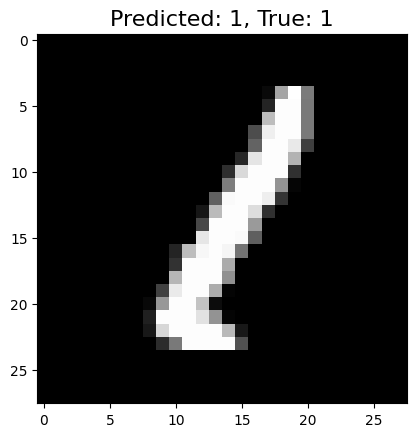

In [33]:
# Single Example
print(len(x_test))
random_idx = np.random.choice(len(x_test))
print(random_idx)

x_sample = x_test.iloc[random_idx]
print(x_sample.shape)

y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.values.reshape(28, 28), cmap='gray')

## Confusion Matrix

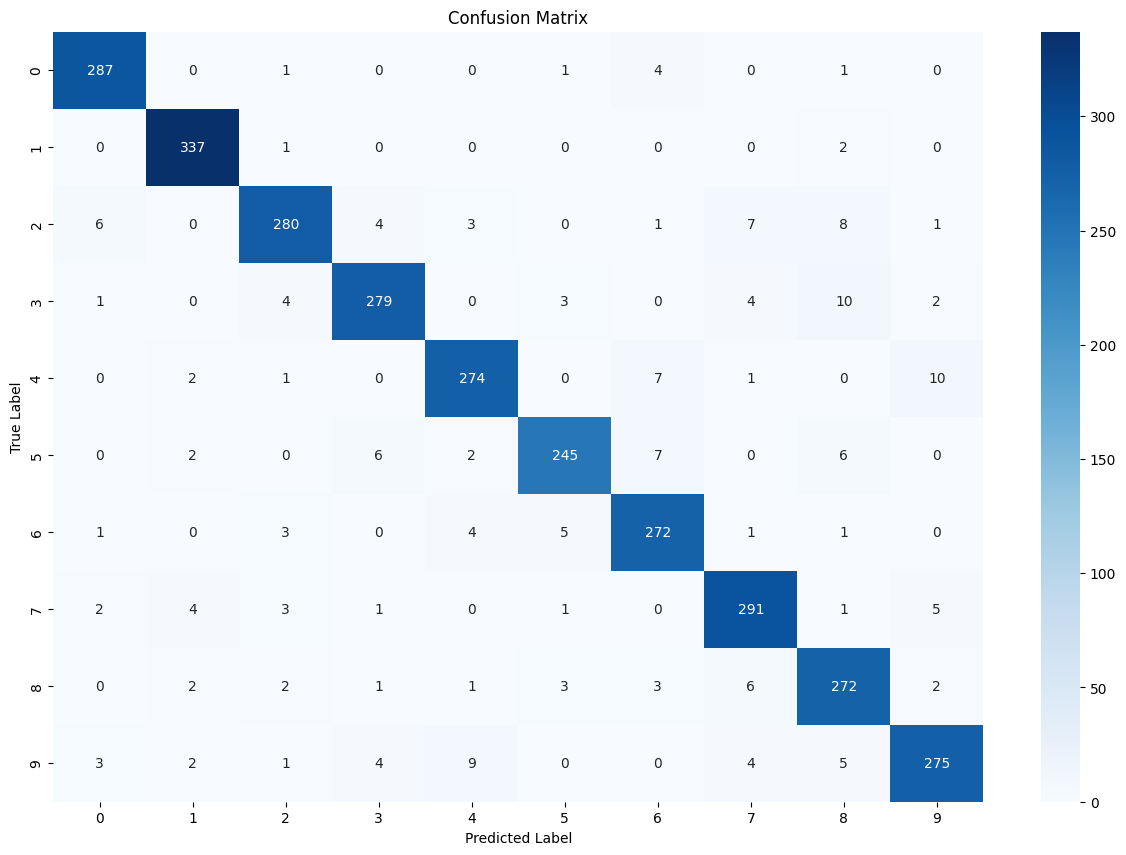

In [34]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');

# Investigate incorrectly predicted images

In [35]:
errors = (y_pred_classes - y_true != 0)
print(errors)
y_pred_classes_errors = y_pred_classes[errors]
print(y_pred_classes_errors)
y_pred_errors = y_pred[errors]
print(y_pred_classes)
y_true_errors = y_true[errors]
print(y_true_errors)
x_test_errors = x_test[errors]
print(x_test_errors)

[False False False ...  True False False]
[2 2 1 8 9 7 9 1 7 6 2 8 9 4 5 7 2 3 8 1 4 4 0 8 5 4 7 0 7 9 8 8 4 9 7 6 4
 5 9 9 3 1 2 2 9 2 0 0 6 3 7 6 1 5 0 7 9 3 9 7 2 5 3 6 0 4 8 8 8 8 4 0 3 6
 2 7 1 7 7 7 8 0 2 5 4 9 0 8 3 4 7 9 1 3 6 5 9 8 8 5 7 8 7 6 8 9 7 7 5 8 6
 8 1 3 8 3 4 2 4 4 8 1 0 6 3 8 6 9 0 8 3 4 9 7 4 2 6 3 8 8 0 6 5 7 6 8 1 6
 5 9 6 3 8 7 5 9 4 0 2 1 7 6 8 8 9 8 1 8 2 8 6 2 6 8 6 4 7 4 3 6 5 4 3 9 2
 8 6 8]
[6 1 9 ... 8 8 9]
[8 6 7 2 7 8 3 9 8 4 7 5 7 5 3 3 0 5 3 7 6 9 7 2 6 2 2 9 3 4 2 5 2 3 3 8 9
 6 4 4 9 9 4 1 8 3 9 2 0 5 8 4 7 6 2 9 4 8 4 4 3 0 5 4 2 8 2 5 3 0 6 6 5 0
 7 8 8 9 3 9 3 2 6 8 9 8 2 2 2 6 2 2 7 2 8 6 4 3 9 8 2 7 8 5 3 4 2 2 3 5 4
 3 5 9 1 2 9 8 2 9 2 8 9 5 9 3 4 7 3 5 7 9 4 2 9 9 5 5 5 1 7 5 8 9 5 3 5 8
 6 4 0 9 2 2 3 7 9 2 3 4 6 2 9 9 4 2 4 6 3 9 4 6 0 3 5 5 8 6 5 5 7 9 2 7 7
 3 4 9]
        0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.658  0.659  \
1100  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
1568  0.0  0.0  0.0 

In [36]:
y_pred_errors_probability = np.max(y_pred_errors, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-5:] # 5 last ones

5
15
84
185
153
57


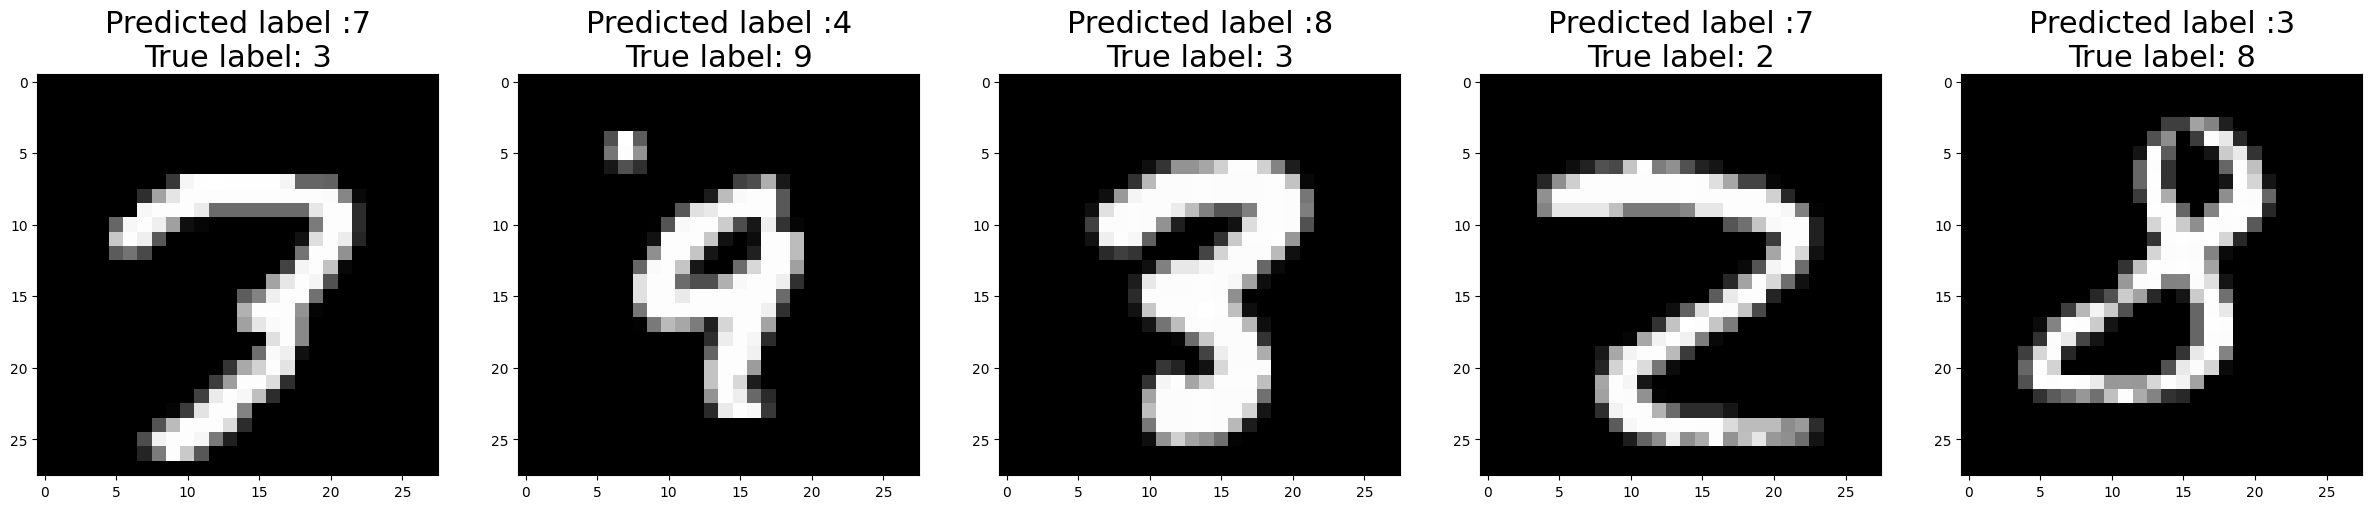

In [37]:
# Show Top Errors
num = len(top_idx_diff_errors)
print(num)
f, ax = plt.subplots(1, num, figsize=(30,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  print(idx)  
  sample = x_test_errors.iloc[idx]
  # print(sample)
  sample = sample.values.reshape(28,28)
  y_t = y_true_errors[idx]
  y_p = y_pred_classes_errors[idx]  
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label :{}\nTrue label: {}".format(y_p, y_t), fontsize=22)

# CNN(Convolutional Neural Network):
## Create Model with Conv2D, Dense layers with 2D image i.e; 28 x 28

In [27]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.25))
cnn_model.add(Dense(10, activation='softmax'))

cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,322 (364.54 KB)

 Trainable params: 93,322 (364.54 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Convert flatten images in X_train, X_test to 2d 28 x 28
X_train_2d = X_train.values.reshape(-1, 28, 28)
X_test_2d = X_test.values.reshape(-1, 28, 28)

print(X_train_2d.shape)
print(X_test_2d.shape)

(59999, 28, 28)
(9999, 28, 28)


In [31]:
cnn_model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])


In [32]:
cnn_model.fit(X_train_2d, y_train, epochs=10, batch_size = 128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.8266 - loss: 1.6262 
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9812 - loss: 0.0642
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9881 - loss: 0.0384
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9899 - loss: 0.0311
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9932 - loss: 0.0216
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9950 - loss: 0.0182
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9954 - loss: 0.0160
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9959 - loss: 0.0129
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9956 - loss: 0.0147
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9967 - loss: 0.0119


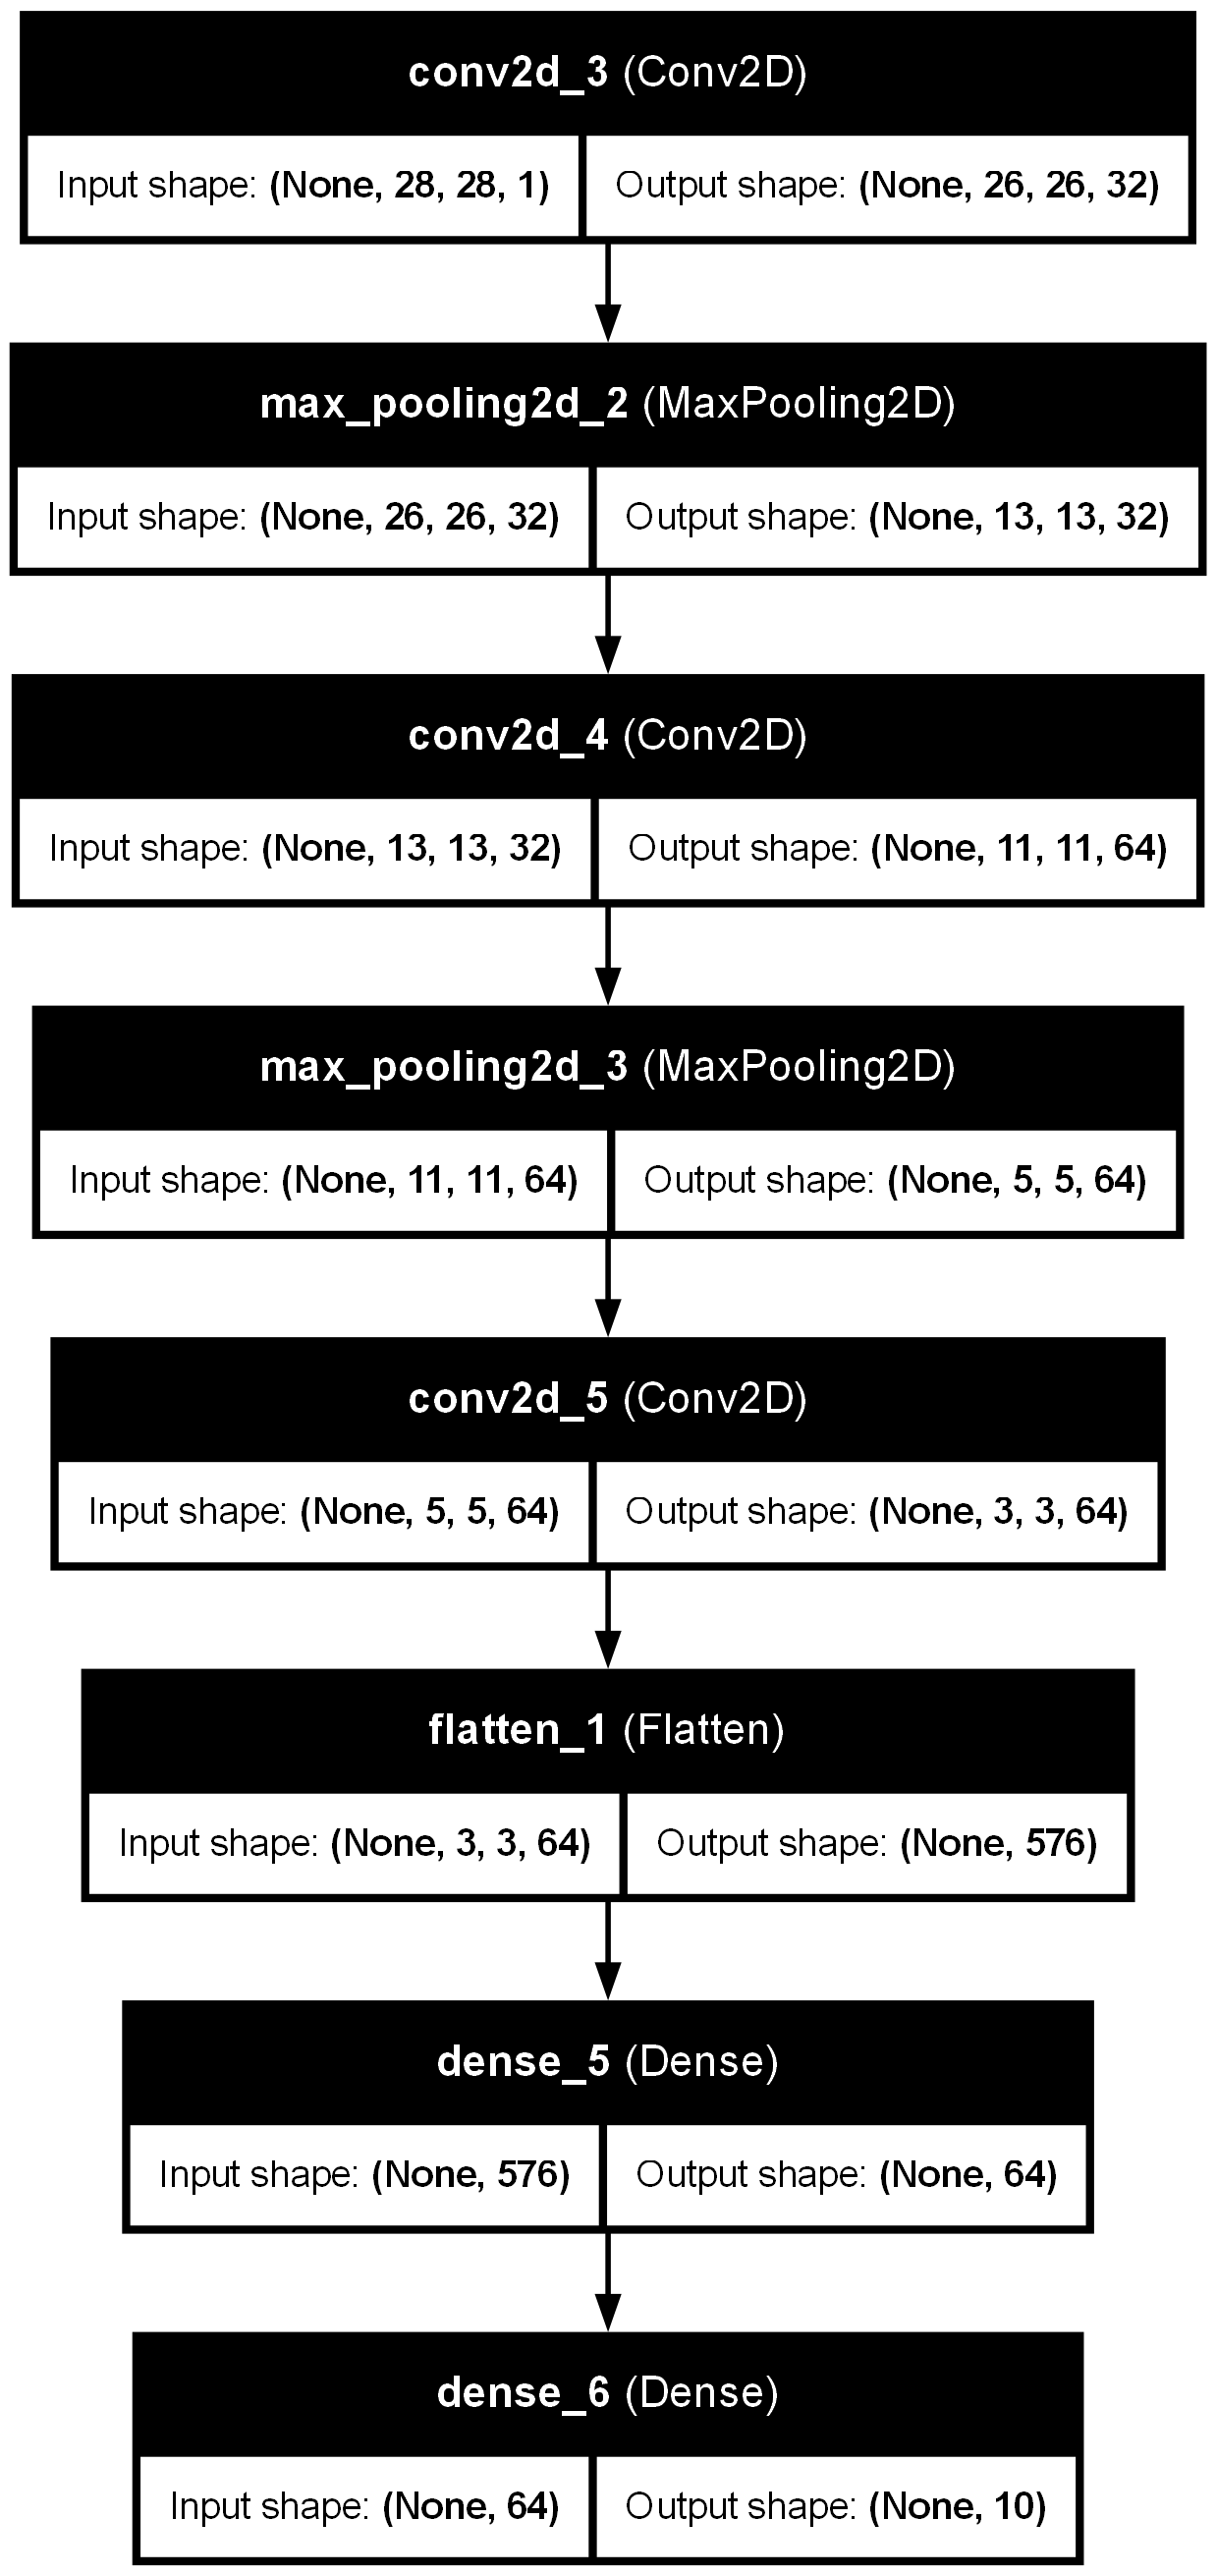

In [49]:
plot_model(cnn_model, to_file='cnn_model2.png', show_shapes=True, show_layer_names=True)

In [34]:
cnn_model.evaluate(X_test_2d, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9881 - loss: 0.0815       


[0.05936061590909958, 0.9910991191864014]

In [35]:
y_pred_2d = cnn_model.predict(X_test_2d)
y_pred_classes_2D = np.argmax(y_pred_2d, axis=1)
print(y_pred_2d)
print(y_pred_classes_2D)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  
[[1.1847651e-22 3.3029710e-19 1.0000000e+00 ... 4.6266165e-23
  1.5130126e-26 2.0391795e-30]
 [2.3299498e-18 1.0000000e+00 8.2653179e-15 ... 2.1921036e-17
  2.7621436e-14 1.0821239e-16]
 [1.0000000e+00 2.0896808e-22 3.1280636e-17 ... 7.4096225e-18
  9.0643996e-20 1.3658270e-15]
 ...
 [1.7613230e-26 3.0359457e-23 7.2191164e-26 ... 1.0835236e-17
  4.9291600e-16 9.2862720e-18]
 [1.1143691e-29 4.1696476e-27 4.0346731e-36 ... 1.1884760e-31
  4.1312183e-21 3.2693470e-21]
 [2.6066625e-19 6.6402256e-24 3.2398527e-26 ... 1.5748167e-32
  1.1939441e-21 1.3481993e-25]]
[2 1 0 ... 4 5 6]


# Prediction on single image 

9999
9845
(28, 28)


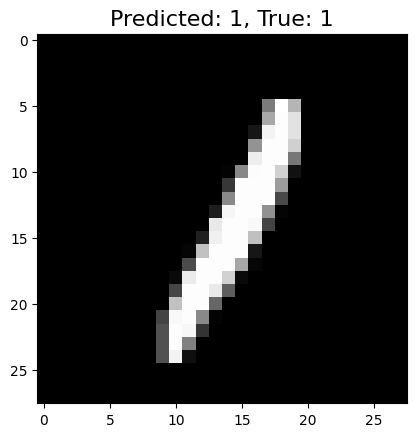

In [36]:
# Single Example
print(len(X_test_2d))
random_idx = np.random.choice(len(X_test_2d))
print(random_idx)

x_sample = X_test_2d[random_idx]
print(x_sample.shape)

y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes_2D[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample, cmap='gray')

# Confusion Matrix 

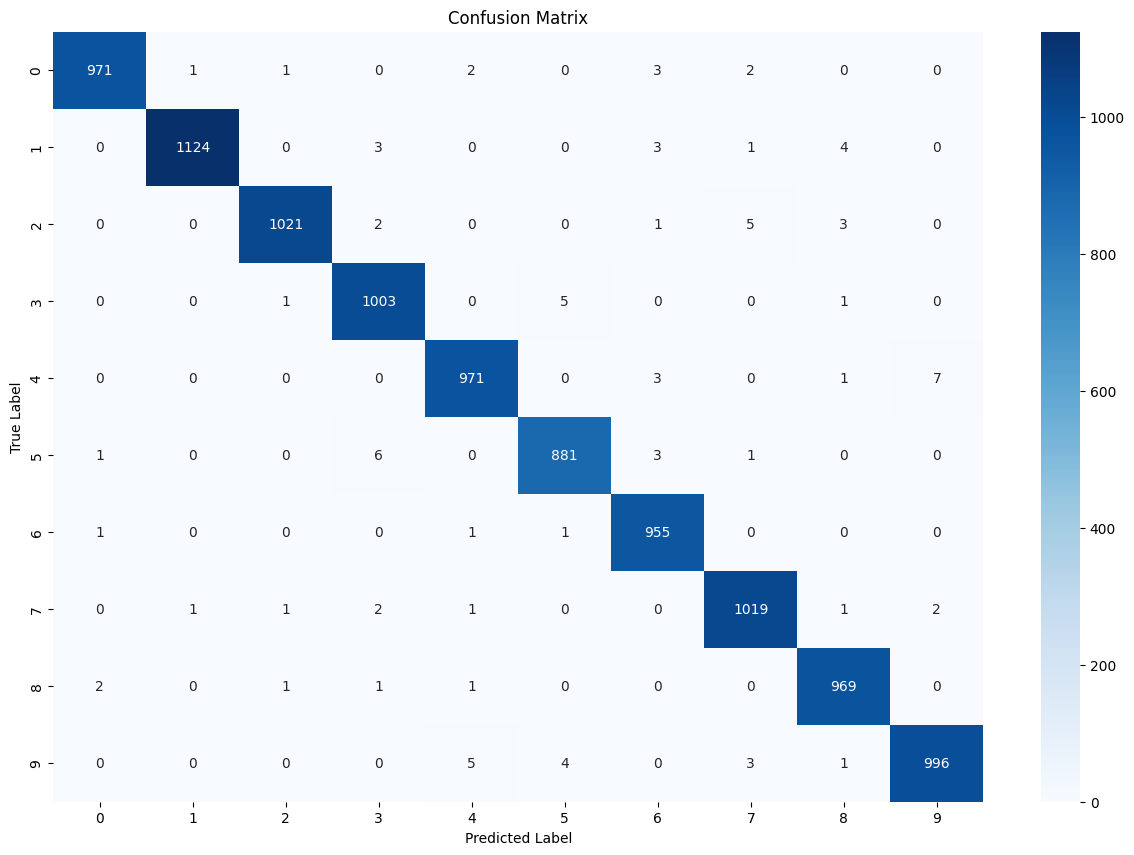

In [37]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes_2D)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');

# Investigate the errors

In [38]:
errors = (y_pred_classes_2D - y_true != 0)
print(errors)
y_pred_classes_errors_2d = y_pred_classes_2D[errors]
print(y_pred_classes_errors_2d)
y_pred_errors_2d = y_pred_2d[errors]
print(y_pred_classes_errors_2d)
y_true_errors_2d = y_true[errors]
print(y_true_errors_2d)
x_test_errors_2d = X_test_2d[errors]
print(x_test_errors)

[False False False ... False False False]
[5 9 6 7 3 5 2 6 7 6 4 3 4 5 5 4 2 4 9 1 7 0 3 3 6 5 3 3 4 9 3 5 2 3 4 8 3
 3 9 0 3 2 5 9 0 4 0 7 6 9 6 8 6 3 6 9 8 7 8 5 4 9 7 6 8 3 3 8 8 5 5 7 8 7
 4 6 6 8 8 4 6 9 8 1 7 7 7 6 7]
[5 9 6 7 3 5 2 6 7 6 4 3 4 5 5 4 2 4 9 1 7 0 3 3 6 5 3 3 4 9 3 5 2 3 4 8 3
 3 9 0 3 2 5 9 0 4 0 7 6 9 6 8 6 3 6 9 8 7 8 5 4 9 7 6 8 3 3 8 8 5 5 7 8 7
 4 6 6 8 8 4 6 9 8 1 7 7 7 6 7]
[9 4 4 2 5 3 8 2 2 5 0 7 9 3 6 7 7 9 4 7 5 8 5 1 0 9 5 8 9 4 1 3 0 5 9 2 2
 5 4 8 7 3 3 7 6 6 5 0 1 4 4 7 5 1 4 7 9 2 1 3 9 4 1 1 1 2 5 3 1 9 9 9 2 0
 8 0 0 4 2 0 1 4 1 0 9 9 2 5 2]
        0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.658  0.659  \
148   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
246   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
258   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
320   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
339   0.0  0.0  0.0  0.0  0

In [39]:
y_pred_errors_probability = np.max(y_pred_errors_2d, axis=1)
true_probability_errors = np.diagonal(np.take(y_pred_errors_2d, y_true_errors_2d, axis=1))
diff_errors_pred_true = y_pred_errors_probability - true_probability_errors

# Get list of indices of sorted differences
sorted_idx_diff_errors = np.argsort(diff_errors_pred_true)
top_idx_diff_errors = sorted_idx_diff_errors[-5:] # 5 last ones

5
42
37
45
87
88


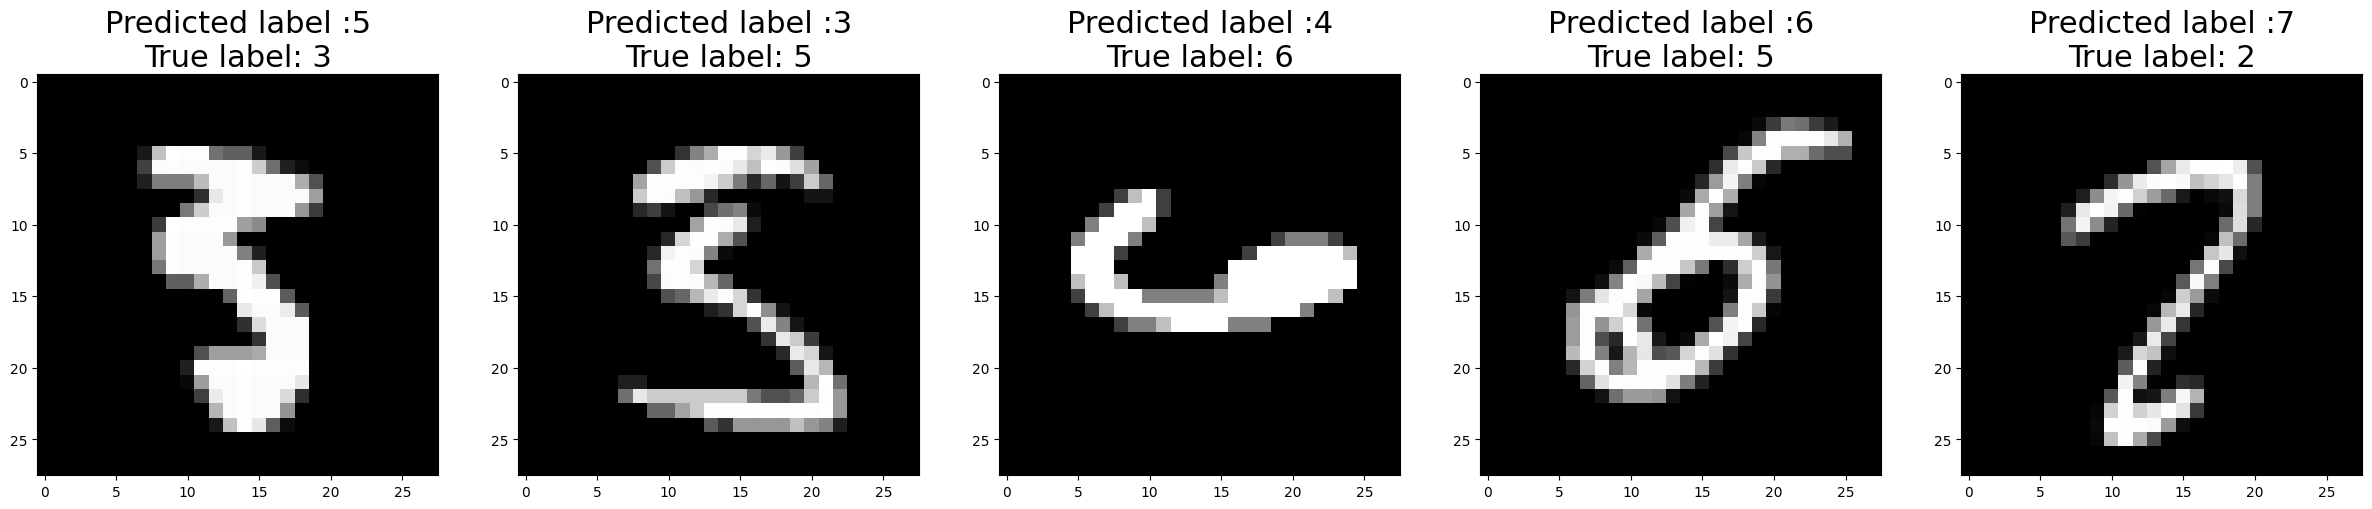

In [40]:
# Show Top Errors
num = len(top_idx_diff_errors)
print(num)
f, ax = plt.subplots(1, num, figsize=(30,30))

for i in range(0, num):
  idx = top_idx_diff_errors[i]
  print(idx)  
  sample = x_test_errors_2d[idx]
  # print(sample)
  # sample = sample.values.reshape(28,28)
  y_t = y_true_errors_2d[idx]
  y_p = y_pred_classes_errors_2d[idx]  
  ax[i].imshow(sample, cmap='gray')
  ax[i].set_title("Predicted label :{}\nTrue label: {}".format(y_p, y_t), fontsize=22)

# FCNN: Hyper Parameter tuning using keras classifier and GridSearchCV

In [53]:
# Function to create model, required for KerasClassifier
def build_model(optimizer='adam', init='glorot_uniform'):
    fcnn_model = Sequential()
    fcnn_model.add(Input(shape=(784,)))
    fcnn_model.add(Dense(units=128, activation='relu', kernel_initializer=init))
    fcnn_model.add(Dropout(0.25))
    fcnn_model.add(Dense(units=128, activation='relu', kernel_initializer=init))
    fcnn_model.add(Dropout(0.5))
    fcnn_model.add(Dense(units=10, activation='softmax', kernel_initializer=init))    
    fcnn_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    fcnn_model.summary()    
    plot_model(fcnn_model, to_file='fcnn_model_gridsearchcv.png', show_shapes=True, show_layer_names=True)
    return fcnn_model

# Create the KerasClassifier
model = KerasClassifier(model=build_model, verbose=1, init='glorot_uniform')

# Define the grid search parameters
param_grid = {
    'batch_size': [128, 128 * 2, 128 * 3],
    'epochs': [10, 15],
    'optimizer': ['adam', 'rmsprop']
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(x_train.values, y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6592 - loss: 1.0652
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9183 - loss: 0.2797
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9397 - loss: 0.2125
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9485 - loss: 0.1705
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9587 - loss: 0.1459
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9608 - loss: 0.1329
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9653 - loss: 0.1158
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9678 - loss: 0.1064
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9716 - loss: 0.0969
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9721 - loss: 0.0912
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9738 - loss: 0.0895
Epoch 12/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

In [54]:
# Get the best model
best_model = grid_result.best_estimator_

# Make predictions
predictions = best_model.predict(x_test)
probabilities = best_model.predict_proba(x_test)

# Output predictions
print("Predictions:", predictions)
print("Probabilities:", probabilities)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predictions: [[0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Probabilities: [[6.5628106e-12 3.2312935e-05 9.9996674e-01 ... 3.7562673e-09
  1.4276576e-10 7.8166487e-16]
 [1.1225534e-08 9.9994636e-01 3.6357483e-06 ... 2.8977633e-05
  1.2293303e-05 1.8476490e-08]
 [9.9958962e-01 2.4756798e-07 6.4208245e-05 ... 3.5121147e-06
  5.5679425e-07 1.7631246e-06]
 ...
 [8.8085702e-12 6.7979784e-12 4.7080950e-12 ... 8.8026447e-08
  3.6598660e-10 2.8087069e-07]
 [1.5044614e-08 1.1580037e-11 1.8476738e-11 ... 2.4395434e-11
  2.3761954e-06 5.9525616e-09]
 [1.3983007e-09 4.3390663e-11 6.5403502e-11 ... 1.7170953e-15
  5.4711152e-10 6.5869490e-14]]


In [55]:
y_pred_classes = np.argmax(probabilities, axis=1)
print(y_pred_classes)

[2 1 0 ... 4 5 6]


9999
9845
(784,)


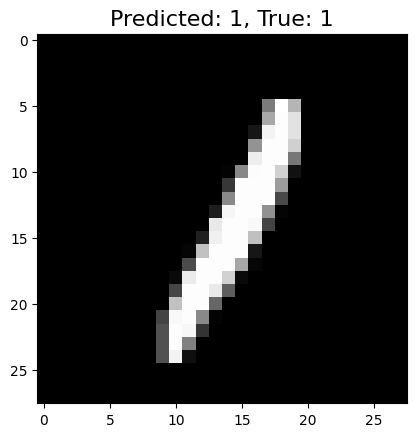

In [56]:
# Single Example
print(len(x_test))
random_idx = np.random.choice(len(x_test))
print(random_idx)

x_sample = x_test.iloc[random_idx]
print(x_sample.shape)

y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes_2D[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.values.reshape(28, 28), cmap='gray')

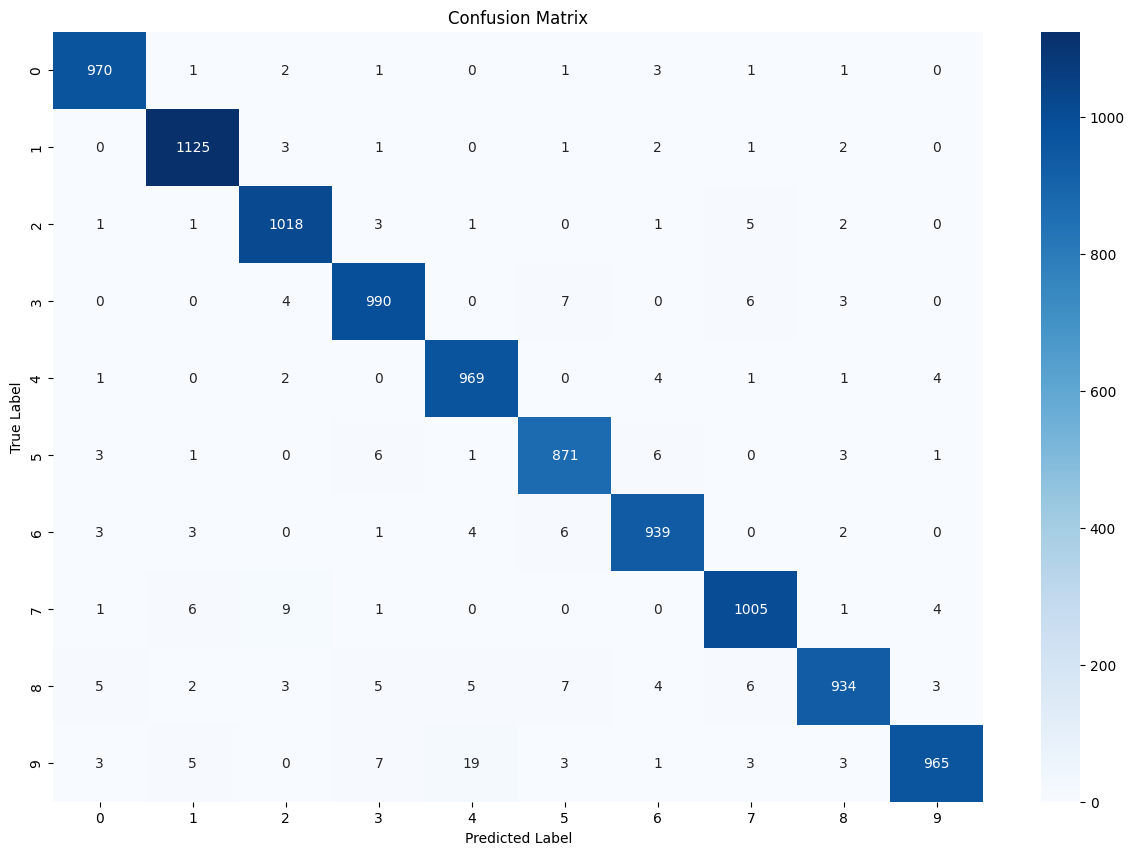

In [58]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');

In [59]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, recall_score

# Get the best model
best_model = grid_result.best_estimator_

# Make predictions
y_pred = best_model.predict(x_test)
y_pred_proba = best_model.predict_proba(x_test)

# Calculate accuracy and log loss
test_acc = accuracy_score(y_test, y_pred)
test_loss = log_loss(y_test, y_pred_proba)


print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

# Calculate ROC AUC score and recall score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
recall = recall_score(y_test, y_pred, average='macro')

print("ROC AUC Score: {}".format(roc_auc))
print("Recall Score: {}".format(recall))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Loss: 0.07432353228390735, Test Accuracy: 0.9786978697869787
ROC AUC Score: 0.9996143136276607
Recall Score: 0.9784906688145034


# CNN: Hyper Parameter tuning using keras classifier and GridSearchCV

In [197]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', init='glorot_uniform'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

x_train_2d = x_train.values.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)
x_test_2d = x_test.values.reshape(-1, 28, 28, 1)    # Reshape to (num_samples, 28, 28, 1)

# Create the KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=1, init='glorot_uniform')

# Define the grid search parameters
param_grid = {
    'batch_size': [32, 64],
    'epochs': [5, 10],
    'optimizer': ['adam', 'rmsprop']
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search
grid_result = grid.fit(x_train_2d, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



c:\Users\punit\miniconda3\envs\advanced_mlops_env\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\punit\miniconda3\envs\advanced_mlops_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.7653 - loss: 0.7115
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.9532 - loss: 0.1594
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9663 - loss: 0.1164
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9690 - loss: 0.0999
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9734 - loss: 0.0911
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 27ms/step - accuracy: 0.9765 - loss: 0.0784
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9785 - loss: 0.0732
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9806 - loss: 0.0664
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.9810 - loss: 0.0621
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step - accuracy: 0.9824 - loss: 0.0573
Best: 0.989333 using {'batch_size': 64, 'epochs': 10, 'optimizer': 'adam'}
0.986850 (0.000204) with: {'batch_size': 32,

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Loss: 0.024024625133564997, Test Accuracy: 0.9921992199219922
ROC AUC Score: 0.9999653532567061
Recall Score: 0.9920976911648985
9999
9845
(28, 28, 1)


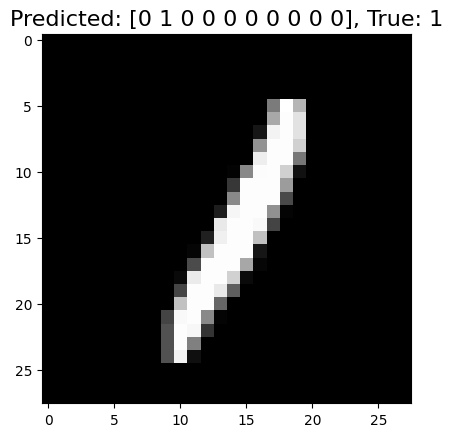

In [198]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, recall_score

# Get the best model
best_model = grid_result.best_estimator_

# Make predictions
y_pred = best_model.predict(x_test_2d)
y_pred_proba = best_model.predict_proba(x_test_2d)

# Calculate accuracy and log loss
test_acc = accuracy_score(y_test, y_pred)
test_loss = log_loss(y_test, y_pred_proba)


print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

# Calculate ROC AUC score and recall score
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
recall = recall_score(y_test, y_pred, average='macro')

print("ROC AUC Score: {}".format(roc_auc))
print("Recall Score: {}".format(recall))

# Single Example
print(len(x_test_2d))
random_idx = np.random.choice(len(x_test_2d))
print(random_idx)

x_sample = x_test_2d[random_idx]
print(x_sample.shape)

y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample, cmap='gray')

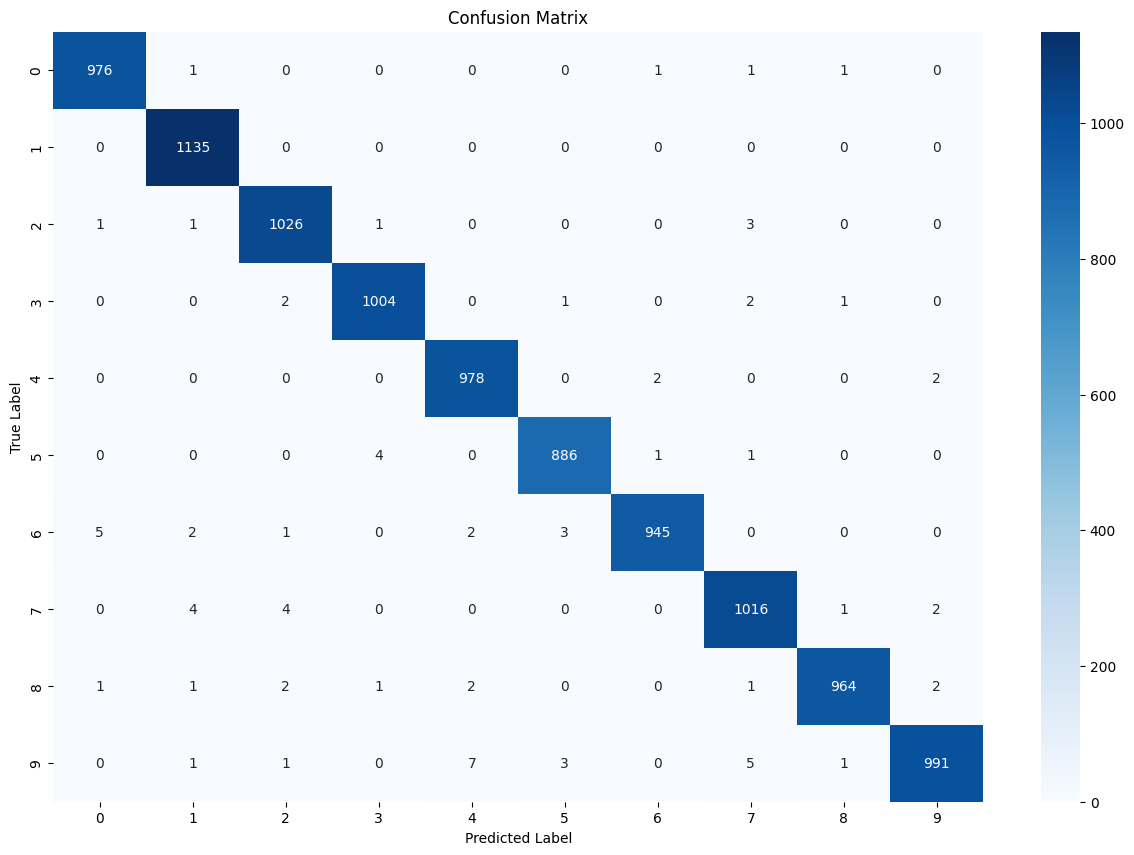

In [199]:
# Convert predicted probabilities to discrete class labels
y_pred_classes = np.argmax(y_pred_proba, axis=1)

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');